RUN SBI-SGM in alpha, new bounds, new SGM, only three parameters needed

parameters order is  :tauG,speed,alpha (In second)


I run on all bands (on Aug 24, 2023). 

1. We remove 4 bad channels 

2. All diag ws are 1


In [13]:
import sys  
def is_jupyter():  
    if 'ipykernel' in sys.modules:  
        return True  
    else:  
        return False  

In [14]:
RUN_PYTHON_SCRIPT = not is_jupyter()
SAVE_PREFIX = "rawfc"

'rawfc'

## Import some pkgs

In [3]:
import sys
sys.path.append("../../mypkg")

import scipy
import itertools

import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import trange
from scipy.io import loadmat
from functools import partial
from easydict import EasyDict as edict

In [4]:
# SBI and torch
from sbi.inference.base import infer
from sbi.inference import SNPE, prepare_for_sbi, simulate_for_sbi
from sbi import analysis
from sbi.utils.get_nn_models import posterior_nn
from sbi import utils as sutils

import torch.nn as nn
import torch.nn.functional as F
import torch
from torch.distributions.multivariate_normal import MultivariateNormal

In [5]:
# my own fns
from brain import Brain
from FC_utils import build_fc_freq_m
from constants import RES_ROOT, DATA_ROOT
from utils.misc import load_pkl, save_pkl
from utils.reparam import theta_raw_2out, logistic_np, logistic_torch

In [6]:
import argparse

if RUN_PYTHON_SCRIPT:
    parser = argparse.ArgumentParser(description='RUN SBI-FC allband')
    parser.add_argument('--noise_sd', default=0.2, type=float, help='the noise sd added to data')
    args = parser.parse_args()

## Some fns

In [7]:
_minmax_vec = lambda x: (x-np.min(x))/(np.max(x)-np.min(x))

<function __main__.<lambda>(x)>

In [8]:
# transfer vec to a sym mat
def vec_2mat(vec):
    mat = np.zeros((68, 68))
    mat[np.triu_indices(68, k = 1)] = vec
    mat = mat + mat.T
    return mat

In [9]:
def get_mode(x):
    kde_est = scipy.stats.gaussian_kde(x)
    xs = np.linspace(x.min(), x.max(), 500)
    ys = kde_est(xs)
    return xs[np.argmax(ys)]

### Some parameters

In [10]:
# SC
ind_conn_xr = xr.open_dataarray(DATA_ROOT/'individual_connectomes_reordered.nc')
ind_conn = ind_conn_xr.values

# PSD
ind_psd_xr = xr.open_dataarray(DATA_ROOT/'individual_psd_reordered_matlab.nc')
ind_psd = ind_psd_xr.values
fvec = ind_psd_xr["frequencies"].values;

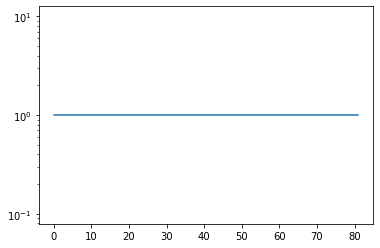

In [11]:
from scipy.io import loadmat
# The array is ordered as in ‘alpha’, ‘beta_l’, ‘delta’, ‘theta’
#diag_ws = np.abs(diag_ws).mean(axis=(1, 2))
diag_ws = np.ones(82)
#diag_ws[0] = 1 # remove it
# normalized diag_ws (to mean 1 or max 1) (on May 10, 2023)
# or log(ws/min(ws)) still remove the first term (on May 10, 2023)
if not RUN_PYTHON_SCRIPT:
    plt.plot(diag_ws)
    plt.yscale("log")

In [12]:
_paras = edict()
_paras.delta = [2, 3.5]
_paras.theta = [4, 7]
_paras.alpha = [8, 12]
_paras.beta_l = [13, 20]

In [16]:
paras = edict()

paras.bands = ["delta", "theta", "alpha", "beta_l"]
paras.freqranges =  [np.linspace(_paras[band ][0], _paras[band][1], 5) 
                     for band in paras.bands]
paras.diag_ws = diag_ws
print(paras.freqranges)
paras.fs = 600
paras.num_nodes = 86 # Number of cortical (68) + subcortical nodes
#paras.par_low = np.asarray([0.005,0.005,0.005,5, 0.1,0.001,0.001])
#paras.par_high = np.asarray([0.03, 0.20, 0.03,20,  1,    2,  0.7])
#paras.names = ["Taue", "Taui", "TauC", "Speed", "alpha", "gii", "gei"]
paras.par_low = np.asarray([0.005, 5, 0.1])
paras.par_high = np.asarray([0.03, 20, 1])
paras.names = ["TauC", "Speed", "alpha"]
paras.prior_bds = np.array([paras.par_low, paras.par_high]).T
paras.prior_sd = 10
paras.add_v = 0.01

paras.SBI_paras = edict()
paras.SBI_paras.num_prior_sps = int(1e4)
paras.SBI_paras.density_model = "nsf"
paras.SBI_paras.num_round = 2 # 3
if RUN_PYTHON_SCRIPT:
    paras.SBI_paras.noise_sd = args.noise_sd
else:
    paras.SBI_paras.noise_sd = 0.2
print(paras.diag_ws)

[array([2.   , 2.375, 2.75 , 3.125, 3.5  ]), array([4.  , 4.75, 5.5 , 6.25, 7.  ]), array([ 8.,  9., 10., 11., 12.]), array([13.  , 14.75, 16.5 , 18.25, 20.  ])]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [12]:
# fn for reparemetering
_map_fn_torch = partial(logistic_torch, k=0.1)
_theta_raw_2out = partial(theta_raw_2out, map_fn=partial(logistic_np, k=0.1))

functools.partial(<function theta_raw_2out at 0x7f8e53175820>, map_fn=functools.partial(<function logistic_np at 0x7f8e53175790>, k=0.1))

### Load the data

In [13]:

def _add_v2con(cur_ind_conn):
    cur_ind_conn = cur_ind_conn.copy()
    add_v = np.quantile(cur_ind_conn, 0.99)*paras.add_v # tuning 0.1
    np.fill_diagonal(cur_ind_conn[:34, 34:68], np.diag(cur_ind_conn[:34, 34:68]) + add_v)
    np.fill_diagonal(cur_ind_conn[34:68, :34], np.diag(cur_ind_conn[34:68, :34]) + add_v)
    np.fill_diagonal(cur_ind_conn[68:77, 77:], np.diag(cur_ind_conn[68:77, 77:]) + add_v)
    np.fill_diagonal(cur_ind_conn[77:, 68:77], np.diag(cur_ind_conn[77:, 68:77]) + add_v)
    return cur_ind_conn

if paras.add_v != 0:
    print(f"Add {paras.add_v} on diag")
    ind_conn_adds = [_add_v2con(ind_conn[:, :, ix]) for ix in range(36)]
    ind_conn = np.transpose(np.array(ind_conn_adds), (1, 2, 0))

Add 0.01 on diag


In [14]:
# em FC
fc_root = RES_ROOT/"emp_fcs"
fcss = []
for band in paras.bands:
    def _get_fc(sub_ix, bd):
        fil = list(fc_root.rglob(f"*{bd}*/sub{sub_ix}.pkl"))[0]
        return load_pkl(fil, verbose=False)
    
    fcs = np.array([_get_fc(sub_ix, band) for sub_ix in range(36)]);
    fcss.append(fcs)

## SBI

### Prior

In [15]:
prior = MultivariateNormal(loc=torch.zeros(3), covariance_matrix=torch.eye(3)*(paras.prior_sd**2))

MultivariateNormal(loc: torch.Size([3]), covariance_matrix: torch.Size([3, 3]))

In [16]:
def simulator(raw_params, brain, noise_sd, prior_bds, freqranges, diag_ws):
    params = []
    for raw_param, prior_bd in zip(raw_params, prior_bds):
        param =  _map_fn_torch(raw_param)*(prior_bd[1]-prior_bd[0]) + prior_bd[0]
        params.append(param)
    params = torch.tensor(params)
    
    params_dict = dict()
    params_dict["tauC"] =  params[0].item()
    params_dict["speed"] =  params[1].item()
    params_dict["alpha"] =  params[2].item()
    ress = []
    for freqrange in freqranges:
        modelFC = build_fc_freq_m(brain, params_dict, freqrange, diag_ws)
        modelFC_abs = np.abs(modelFC[:68, :68])
        res = _minmax_vec(modelFC_abs[np.triu_indices(68, k = 1)])
        ress.append(res)
    ress = np.concatenate(ress)
    noise =  np.random.randn(*ress.shape)*noise_sd
    return (ress+ noise).flatten()

In [19]:
for cur_ind_idx in range(0, 36):
    print(cur_ind_idx)
    save_fil = f"{SAVE_PREFIX}_posteriorMRmulDiffNum_{'-'.join(paras.bands)}_" + \
               f"num{paras.SBI_paras.num_prior_sps}_" + \
               f"density{paras.SBI_paras.density_model}_" + \
               f"MR{paras.SBI_paras.num_round}_" + \
               f"noise_sd{paras.SBI_paras.noise_sd*100:.0f}_" +\
               f"addv{paras.add_v*100:.0f}" +\
               f"/ind{cur_ind_idx}.pkl"
    if (RES_ROOT/save_fil).exists():
        # thanks to the buggy SCS
        continue
    
    
    # create spectrome brain:
    brain = Brain.Brain()
    brain.add_connectome(DATA_ROOT) # grabs distance matrix
    # re-ordering for DK atlas and normalizing the connectomes:
    brain.reorder_connectome(brain.connectome, brain.distance_matrix)
    brain.connectome =  ind_conn[:, :, cur_ind_idx] # re-assign connectome to individual connectome
    brain.bi_symmetric_c()
    brain.reduce_extreme_dir()
    
    simulator_sp = partial(simulator, 
                           brain=brain, 
                           noise_sd=paras.SBI_paras.noise_sd, 
                           prior_bds=paras.prior_bds, 
                           freqranges=paras.freqranges, 
                           diag_ws=paras.diag_ws)
    simulator_wrapper, prior = prepare_for_sbi(simulator_sp, prior)
    inference = SNPE(prior=prior, density_estimator=paras.SBI_paras.density_model)
    proposal = prior 
    
    #the observed data
    res_vecs = []
    for fcs in fcss:
        cur_obs_FC = np.abs(fcs[cur_ind_idx])
        res_vec = _minmax_vec(cur_obs_FC[np.triu_indices(68, k = 1)])
        res_vecs.append(res_vec)
    res_vecs = np.concatenate(res_vecs)
    curX = torch.Tensor(res_vecs)
    num_spss = [1000, 1000, 1000]
    #num_spss = [10000, 1000, 1000]
    for ix in range(paras.SBI_paras.num_round):
        cur_num_sps = num_spss[ix]
        theta, x = simulate_for_sbi(simulator_wrapper, proposal,
                                    num_simulations=int(cur_num_sps),
                                    num_workers=20)
        density_estimator = inference.append_simulations(
                            theta, x, proposal=proposal
                            ).train()
        posterior = inference.build_posterior(density_estimator)
        
        proposal = posterior.set_default_x(curX)
    
    save_pkl(RES_ROOT/save_fil, proposal)

0


Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

 Neural network successfully converged after 59 epochs.

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

/home/hujin/.local/lib/python3.9/site-packages/nflows/transforms/lu.py:80: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:2189.)
  outputs, _ = torch.triangular_solve(


Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 21 epochs./data/rajlab1/user_data/jin/MyResearch/SBI-SGM-FC/notebooks/new_sgm/../../mypkg/../results/rawfc_posteriorMRmulDiffNum_delta-theta-alpha-beta_l_num10000_densitynsf_MR2_noise_sd20_addv1
Create a folder /data/rajlab1/user_data/jin/MyResearch/SBI-SGM-FC/notebooks/new_sgm/../../mypkg/../results/rawfc_posteriorMRmulDiffNum_delta-theta-alpha-beta_l_num10000_densitynsf_MR2_noise_sd20_addv1
Save to /data/rajlab1/user_data/jin/MyResearch/SBI-SGM-FC/notebooks/new_sgm/../../mypkg/../results/rawfc_posteriorMRmulDiffNum_delta-theta-alpha-beta_l_num10000_densitynsf_MR2_noise_sd20_addv1/ind0.pkl
1


Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

 Training neural network. Epochs trained: 19

KeyboardInterrupt: 